In [1]:
import numpy as np
print(np)
%matplotlib nbagg
import matplotlib

<module 'numpy' from '/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/numpy/__init__.py'>


/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import logging

root = logging.root
for h in root.handlers:
    h.setLevel("INFO")

In [3]:
import dedalus.public as de
import numpy as np
import matplotlib.pylab as plt

In [28]:
plt.style.use('ggplot')

In [29]:
nr1 = 128 #128
r_shortgrid = de.Chebyshev('r', nr1, interval=(5, 15))
d1 = de.Domain([r_shortgrid])

nr2 = 192#164
r_longgrid = de.Chebyshev('r', nr2, interval=(5, 15))
d2 = de.Domain([r_longgrid])

In [31]:
# critical parameters
r1 = 5
r2 = 15

goodmanandji = False
if goodmanandji is True:
    Omega1 = 313.55 # rad/s
    Omega2 = 37.9
else:
    Omega1 = 313.55
    Omega2 = 67.0631

c1 = (Omega2*r2**2 - Omega1*r1**2)/(r2**2 - r1**2)
c2 = (r1**2*r2**2*(Omega1 - Omega2))/(r2**2 - r1**2)

zeta_bar = 2*(r2**2 * Omega2 - r1**2 * Omega1)/((r2**2 - r1**2)*np.sqrt(Omega1*Omega2))
print("effective q = {}".format(2 - zeta_bar))

r0 = 10.0
omega0 = c1 + c2/r0**2

if goodmanandji is True:
    # Goodman & Ji 2002
    nu = 3.26e-3 # cm^2/s
    eta = 2000 # cm^2/s
    rho = 6 # g/cm^3
    B0 = 3000 # G

    Rm = (omega0*r0**2)/eta
    Re = (omega0*r0**2)/nu

    #Rm = 4.052031250000001#5.646#Rm = 4.9 #4.879
    iRm = 1.0/Rm
    #Pm = 1.6E-6 #Pm = 0.001
    #Re = Rm/Pm
    iR = 1.0/Re
    q = 1.9368 #q = 1.5
    Q = np.pi/10 #0.748
    beta = 150.79644737231007
else:
    Pm = 1.0E-3
    Rm = 4.9
    Q = 0.75
    beta = 25.0
    iRm = 1.0/Rm
    Re = Rm/Pm
    iR = 1.0/Re
    

effective q = 1.5000004687274147


Nondimensionalize: $(1/(4 \pi \rho)) \rightarrow (2/\beta)$, $\nu \rightarrow 1/Re$, $\eta \rightarrow 1/Rm$, $B_0 \rightarrow 1$

In [32]:
widegap1 = de.EVP(d1,['psi','u', 'A', 'B', 'psir', 'psirr', 'psirrr', 'ur', 'Ar', 'Br'],'sigma')
widegap2 = de.EVP(d2,['psi','u', 'A', 'B', 'psir', 'psirr', 'psirrr', 'ur', 'Ar', 'Br'],'sigma')

for widegap in [widegap1, widegap2]:
    widegap.parameters['k'] = Q
    widegap.parameters['iR'] = iR
    widegap.parameters['iRm'] = iRm
    widegap.parameters['beta'] = beta
    widegap.parameters['c1'] = c1
    widegap.parameters['c2'] = c2
    widegap.parameters['B0'] = 1
    
    widegap.substitutions['ru0'] = '(r*r*c1 + c2)' # u0 = r Omega(r) = Ar + B/r
    widegap.substitutions['rrdu0'] = '(c1*r*r-c2)' # du0/dr = A - B/r^2
    widegap.substitutions['twooverbeta'] = '(2.0/beta)'
    widegap.substitutions['psivisc'] = '(2*r**2*k**2*psir - 2*r**3*k**2*psirr + r**3*k**4*psi + r**3*dr(psirrr) - 3*psir + 3*r*psirr - 2*r**2*psirrr)'
    widegap.substitutions['uvisc'] = '(-r**3*k**2*u + r**3*dr(ur) + r**2*ur - r*u)'
    widegap.substitutions['Avisc'] = '(r*dr(Ar) - r*k**2*A - Ar)' # checked on whiteboard 5/6
    widegap.substitutions['Bvisc'] = '(-r**3*k**2*B + r**3*dr(Br) + r**2*Br - r*B)'

2016-05-11 17:06:57,009 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2016-05-11 17:06:57,010 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


In [33]:
for widegap in [widegap1, widegap2]:
    widegap.add_equation("sigma*(-r**3*k**2*psi + r**3*psirr - r**2*psir) - r**2*2*ru0*1j*k*u + r**3*twooverbeta*B0*1j*k**3*A + twooverbeta*B0*r**2*1j*k*Ar - twooverbeta*r**3*B0*1j*k*dr(Ar) - iR*psivisc = 0") #corrected on whiteboard 5/6
    widegap.add_equation("sigma*r**3*u + 1j*k*ru0*psi + 1j*k*rrdu0*psi - 1j*k*r**3*twooverbeta*B0*B - iR*uvisc = 0") # correct 5/5
    widegap.add_equation("sigma*r*A - r*B0*1j*k*psi - iRm*Avisc = 0")
    widegap.add_equation("sigma*r**3*B + ru0*1j*k*A - r**3*B0*1j*k*u - 1j*k*rrdu0*A - iRm*Bvisc = 0") # correct 5/5
    
    widegap.add_equation("dr(psi) - psir = 0")
    widegap.add_equation("dr(psir) - psirr = 0")
    widegap.add_equation("dr(psirr) - psirrr = 0")
    widegap.add_equation("dr(u) - ur = 0")
    widegap.add_equation("dr(A) - Ar = 0")
    widegap.add_equation("dr(B) - Br = 0")
    
    widegap.add_bc('left(u) = 0')
    widegap.add_bc('right(u) = 0')
    widegap.add_bc('left(psi) = 0')
    widegap.add_bc('right(psi) = 0')
    widegap.add_bc('left(A) = 0')
    widegap.add_bc('right(A) = 0')
    widegap.add_bc('left(psi + r*psir) = 0')
    widegap.add_bc('right(psi + r*psir) = 0')
    widegap.add_bc('left(B + r*Br) = 0')
    widegap.add_bc('right(B + r*Br) = 0')

In [34]:
widegap_solver1 = widegap1.build_solver()
widegap_solver2 = widegap2.build_solver()

In [35]:
widegap_solver1.solve(widegap_solver1.pencils[0])
widegap_solver2.solve(widegap_solver2.pencils[0])

/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: divide by zero encountered in true_divide
  w = alpha / beta
/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/scipy/linalg/decomp.py:56: RuntimeWarning: invalid value encountered in true_divide
  w = alpha / beta


In [36]:
ev1 = widegap_solver1.eigenvalues
ev2 = widegap_solver2.eigenvalues
goodeigs, goodeigs_indices = discard_spurious_eigenvalues(ev1, ev2)


In [37]:
marginal_mode_index = np.where(goodeigs.real == np.nanmax(goodeigs.real))[0][0]

In [38]:
print(marginal_mode_index)
print(int(goodeigs_indices[marginal_mode_index]))
use_indx = int(goodeigs_indices[marginal_mode_index])

93
439


/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/ipykernel/__main__.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/Users/susanclark/dedalus_upgraded2/dedalus/lib/python3.5/site-packages/ipykernel/__main__.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


In [39]:
rr  = r_shortgrid.grid()
evector = widegap_solver1.eigenvectors[use_indx]

In [40]:
widegap_solver1.set_state(use_indx)
data = widegap_solver1.state
psi = data['psi']

print(ev1[use_indx])

(0.249267078753-1.91020821941e-14j)


94 [ -1.04176680e+05 -7.21999073e-14j  -9.32504735e+01 -6.31532895e-12j
  -8.78550990e+01 +1.40284548e-12j  -8.78523776e+01 -3.30700597e-11j
  -8.52164773e+01 -6.18697388e-12j  -8.52137533e+01 +2.32629944e-11j
  -8.26181354e+01 +5.94438502e-12j  -8.26154130e+01 -1.14059232e-11j
  -8.00600806e+01 +4.40915385e-11j  -7.75423056e+01 +4.42189888e-11j
  -7.75395824e+01 -3.93720124e-11j  -7.50648171e+01 -1.71186944e-11j
  -7.26276094e+01 +8.09365035e-12j  -7.26248852e+01 +6.72771166e-12j
  -7.02306872e+01 +4.73116919e-11j  -6.78740465e+01 -1.91943158e-14j
  -6.32816168e+01 +7.63879158e-13j  -5.88503203e+01 +2.65254871e-13j
  -3.91080724e+01 -9.72517079e-12j  -3.56464035e+01 +4.47277524e-10j
  -1.75586240e+00 +0.00000000e+00j  -1.43524183e+00 +0.00000000e+00j
  -1.41864578e+00 +0.00000000e+00j  -1.14285745e+00 +0.00000000e+00j
  -1.12022164e+00 +0.00000000e+00j  -8.99114371e-01 +0.00000000e+00j
  -8.60710030e-01 +0.00000000e+00j  -7.02503483e-01 +0.00000000e+00j
  -6.49641924e-01 +0.00000000e+

<IPython.core.display.Javascript object>


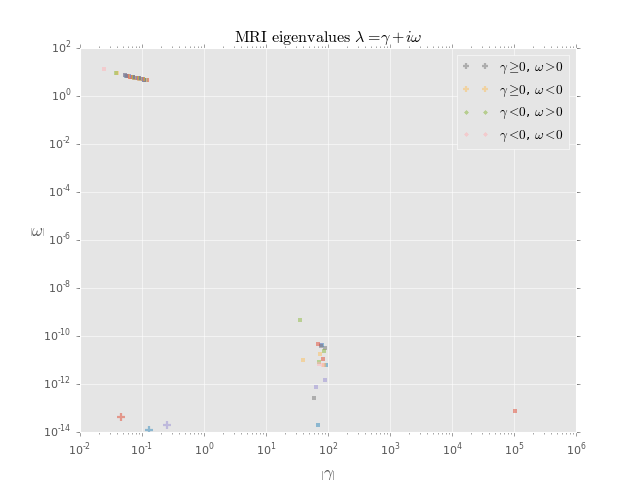

Number of positive real parts 3


In [46]:
print(len(goodeigs), goodeigs)
ploteigs(goodeigs)

<IPython.core.display.Javascript object>


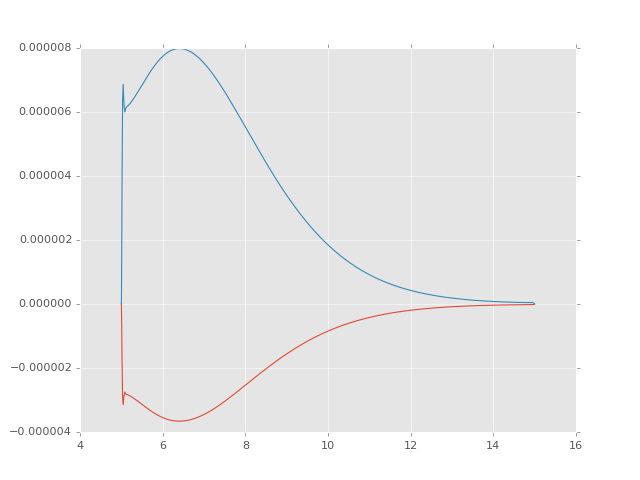

In [58]:
plt.figure()
plt.plot(rr, (data['psi']['g']).real, label='real')
plt.plot(rr, (data['psi']['g']).imag, label='imag')

<IPython.core.display.Javascript object>


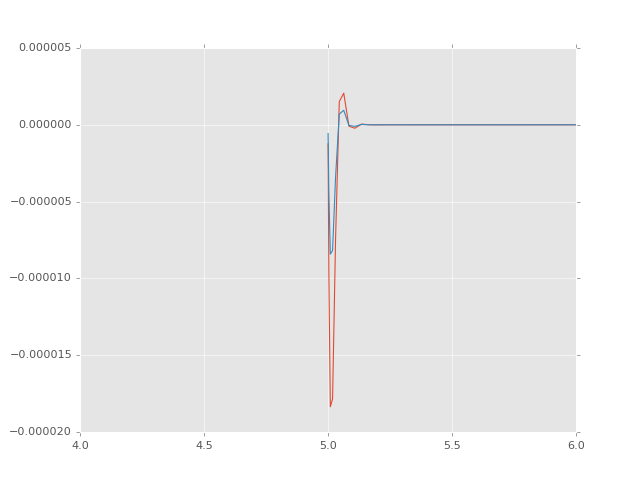

(4, 6)

In [52]:
plt.figure()
plt.plot(rr, (data['u']['g']).real, label='real')
plt.plot(rr, (data['u']['g']).imag, label='imag')
plt.xlim(4, 6)

<IPython.core.display.Javascript object>


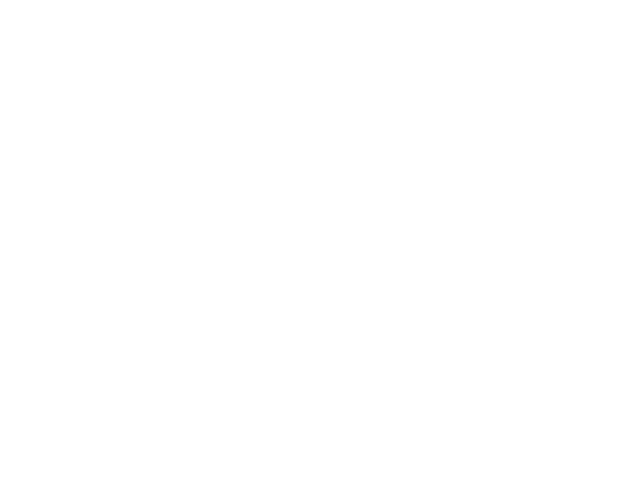

NameError: name 'data2' is not defined

In [43]:
plt.figure()
plt.plot(r_longgrid.grid(), (data2['B']['g']).real, label='real')
plt.plot(r_longgrid.grid(), (data2['B']['g']).imag, ':', label='imag',)

In [45]:
    def discard_spurious_eigenvalues(lambda1, lambda2):
    
        """
        lambda1 :: eigenvalues from low res run
        lambda2 :: eigenvalues from high res run
        
        Solves the linear eigenvalue problem for two different resolutions.
        Returns trustworthy eigenvalues using nearest delta, from Boyd chapter 7.
        """

        # Reverse engineer correct indices to make unsorted list from sorted
        reverse_lambda1_indx = np.arange(len(lambda1)) 
        reverse_lambda2_indx = np.arange(len(lambda2))
    
        lambda1_and_indx = np.asarray(list(zip(lambda1, reverse_lambda1_indx)))
        lambda2_and_indx = np.asarray(list(zip(lambda2, reverse_lambda2_indx)))
        
        # remove nans
        lambda1_and_indx = lambda1_and_indx[np.isfinite(lambda1)]
        lambda2_and_indx = lambda2_and_indx[np.isfinite(lambda2)]
    
        # Sort lambda1 and lambda2 by real parts
        lambda1_and_indx = lambda1_and_indx[np.argsort(lambda1_and_indx[:, 0].real)]
        lambda2_and_indx = lambda2_and_indx[np.argsort(lambda2_and_indx[:, 0].real)]
        
        lambda1_sorted = lambda1_and_indx[:, 0]
        lambda2_sorted = lambda2_and_indx[:, 0]
    
        # Compute sigmas from lower resolution run (gridnum = N1)
        sigmas = np.zeros(len(lambda1_sorted))
        sigmas[0] = np.abs(lambda1_sorted[0] - lambda1_sorted[1])
        sigmas[1:-1] = [0.5*(np.abs(lambda1_sorted[j] - lambda1_sorted[j - 1]) + np.abs(lambda1_sorted[j + 1] - lambda1_sorted[j])) for j in range(1, len(lambda1_sorted) - 1)]
        sigmas[-1] = np.abs(lambda1_sorted[-2] - lambda1_sorted[-1])

        if not (np.isfinite(sigmas)).all():
            print("WARNING: at least one eigenvalue spacings (sigmas) is non-finite (np.inf or np.nan)!")
    
        # Nearest delta
        delta_near = np.array([np.nanmin(np.abs(lambda1_sorted[j] - lambda2_sorted)/sigmas[j]) for j in range(len(lambda1_sorted))])
    
        # Discard eigenvalues with 1/delta_near < 10^6
        lambda1_and_indx = lambda1_and_indx[np.where((1.0/delta_near) > 1E6)]
        #print(lambda1_and_indx)
        
        lambda1 = lambda1_and_indx[:, 0]
        indx = lambda1_and_indx[:, 1]
        
        return lambda1, indx

In [44]:
def ploteigs(goodevals):

    """
    Plot real vs imaginary parts of eigenvalues.
    """

    fig = plt.figure()
    
    # Color is sign of imaginary part
    colors = ["blue" for i in range(len(goodevals))]
    imagpos = np.where(goodevals.imag >= 0)
    for p in imagpos[0]:
        colors[p] = "red"
  
    # Symbol is sign of real part
    symbols = ["." for i in range(len(goodevals))]
    thickness = np.zeros(len(goodevals))
    realpos = np.where(goodevals.real >= 0)
    for p in realpos[0]:
        symbols[p] = "+"
        thickness[p] = 2
    
    print("Number of positive real parts", len(realpos[0]))
    
    for x, y, c, s, t in zip(np.abs(goodevals.real), np.abs(goodevals.imag), colors, symbols, thickness):
        plt.plot(x, y, s, c=c, alpha = 0.5, ms = 8, mew = t)
        
    # Dummy plot for legend
    plt.plot(0, 0, '+', c = "red", alpha = 0.5, mew = 2, label = r"$\gamma \geq 0$, $\omega > 0$")
    plt.plot(0, 0, '+', c = "blue", alpha = 0.5, mew = 2, label = r"$\gamma \geq 0$, $\omega < 0$")
    plt.plot(0, 0, '.', c = "red", alpha = 0.5, label = r"$\gamma < 0$, $\omega > 0$")
    plt.plot(0, 0, '.', c = "blue", alpha = 0.5, label = r"$\gamma < 0$, $\omega < 0$")
        
    plt.legend()
        
    plt.loglog()
    plt.xlabel(r"$\left|\gamma\right|$", size = 15)
    plt.ylabel(r"$\left|\omega\right|$", size = 15, rotation = 0)
    plt.title(r"$\mathrm{MRI}$ $\mathrm{eigenvalues}$ $\lambda = \gamma + i \omega$")